# Stats 315B Project

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
names = open('data/features.txt', 'r')
labels = names.readlines()
for i in range(len(labels)):
    labels[i] = labels[i][2:]
    labels[i] = labels[i][:-1]

data = pd.read_csv('data/train/X_train.txt', header=None, delim_whitespace=True, names=labels)

In [3]:
activity = pd.read_csv('data/train/y_train.txt', header=None, delim_whitespace=True, names = ["Activity"])

In [53]:
test_data = pd.read_csv('data/test/X_test.txt', header=None, delim_whitespace=True, names=labels)
test_act = pd.read_csv('data/test/y_test.txt', header=None, delim_whitespace=True, names = ["Activity"])

<AxesSubplot:xlabel='Activity', ylabel='count'>

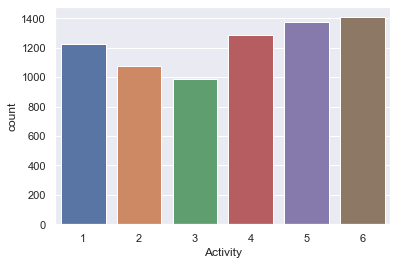

In [6]:
act_order = sorted(activity['Activity'].unique())

sns.countplot(x='Activity', data=activity, order = act_order)

### Decision Tree

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [61]:
decision_tree_model = DecisionTreeClassifier(max_depth=6,random_state=6)
decision_tree_model.fit(data,activity)

train_pred = decision_tree_model.predict(data)
test_pred = decision_tree_model.predict(test_data)

decision_train_accuracy = accuracy_score(activity,train_pred)
decision_validation_accuracy = accuracy_score(test_act,test_pred)

print(decision_train_accuracy)
print(decision_validation_accuracy)

0.9434167573449401
0.8554462164913471


In [62]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
rf_model = RandomForestClassifier(max_depth=9, random_state=6)
rf_model.fit(data,activity)

train_pred = rf_model.predict(data)
test_pred = rf_model.predict(test_data)

rf_train_acc = accuracy_score(activity,train_pred)
rf_test_acc = accuracy_score(test_act,test_pred)

print(rf_train_acc)
print(rf_test_acc)

C:\Users\shaan\AppData\Local\Temp\ipykernel_14180\3222559984.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(data,activity)


0.9982317736670294
0.9216152019002375


In [64]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "max_depth": [3,6,9,12,15,18,21,24,27]
}
est_tree = RandomForestClassifier()
est_tree.fit(data,activity)
search = GridSearchCV(est_tree,param_grid = hyperparameters, cv=6,return_train_score=True)
search.fit(data,activity)
search.best_params_

C:\Users\shaan\AppData\Local\Temp\ipykernel_14180\2890349902.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  est_tree.fit(data,activity)
C:\Users\shaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\shaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_t

{'max_depth': 9}

### Neural Network

In [5]:
import math 

import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters

In [68]:
data_train = torch.tensor(data.values.astype(np.float32))
labels_train = torch.flatten(torch.tensor(activity.values))

data_test = torch.tensor(test_data.values.astype(np.float32))
labels_test = torch.flatten(torch.tensor(test_act.values))

In [75]:
nn_train = torch.utils.data.TensorDataset(data_train, labels_train)

train_loader = torch.utils.data.DataLoader(nn_train, batch_size=100, shuffle=True)

nn_test = torch.utils.data.TensorDataset(data_test, labels_test)

test_loader = torch.utils.data.DataLoader(nn_test, batch_size=100, shuffle=True)


In [76]:
def train(net, train_loader, test_loader,
          num_epochs=10, learning_rate=1e-3,
          compute_accs=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if batch_num % 100 == 0:  # Print every 100 batches                              
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            
            batch_num += 1
        
        if compute_accs:
            tr_ac = accuracy(net, train_loader)
            te_ac = accuracy(net, test_loader)
            train_accs.append(tr_ac)
            test_accs.append(te_ac)
    
    if compute_accs:
        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader):

    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):

    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=model_history['name'] + ' Test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=model_history['name'] + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])
    

In [81]:
class MainNet(nn.Module):
    def __init__(self):
        super(MainNet, self).__init__()

        self.fc1 = nn.Linear(561, 300)
        self.fc2 = nn.Linear(300,100)
        self.fc3 = nn.Linear(100,30)
        self.fc4 = nn.Linear(30,7)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

        

==== Training MainNet ====


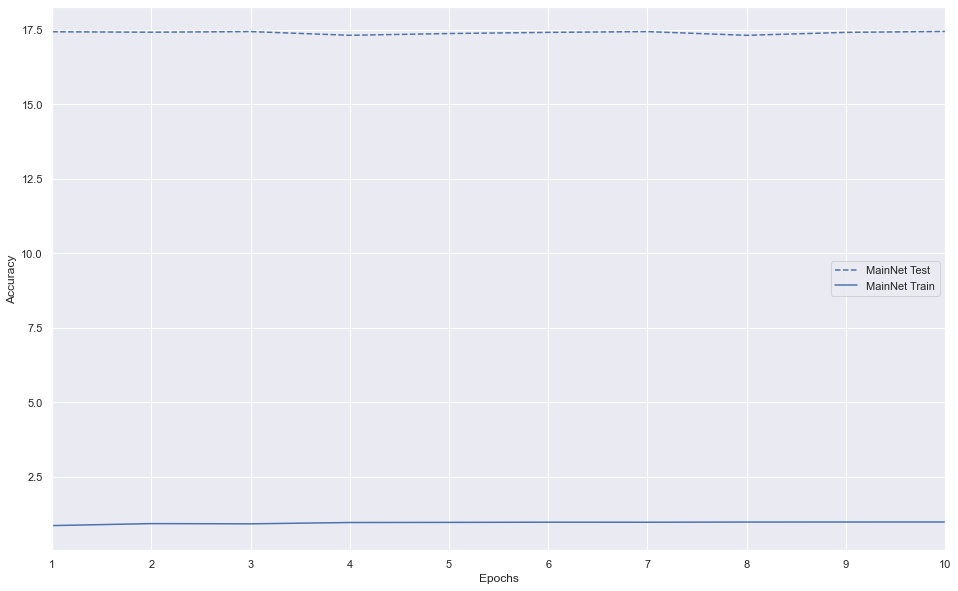

In [82]:
nets = [MainNet()]
histories = []

for net in nets:
    net_name = type(net).__name__
    print(f'==== Training {net_name} ====')
    train_history, test_history = train(net, train_loader, test_loader, 
                                        num_epochs=10, 
                                        learning_rate=1e-3, 
                                        compute_accs=True)
    histories.append({
        'name': net_name, 
        'net': net, 
        'train_accs': train_history, 
        'test_accs': test_history
    })
plot_history(histories)